<img src='https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/Customer_Segmentation-thumbnail-1200x1200-90.jpg' height=600 width=750/>

## Problem Statement

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers. 

- ```You are required to help the manager to predict the right group of the new customers```.

| <font color='blue'><h2>Column Name</h2></font>                       | <font color='blue'><h2>Description</h2></font>                                                                                        |
| ------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------:|
| Id                       | UniqueID                                                                                                   | 
| Gender                          | 	Gender of the customer                                                                  | 
| Ever_Married                            | Marital status of the customer                                                                                    | 
| Age                              | Age of the customer                                                                                 | 
| Graduated                               | Is the customer a graduate?                                                                                   |
| Profession                               | Profession of the customer                                                                                   |
|Work_Experience                             |  Work Experience in years                   |
| Spending_Score                             | Spending score of the customer                                          |
| Family_Size                             | Number of family members for the customer (including the customer)
                                         |
|Var_1                              |   Anonymised Category for the customer        |
| <b><u>Segmentation</u></b>         |	<b><u>(target) Customer Segment of the customer</u></b>                                                 |

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/automobile-customer-segmentation/train.csv
/kaggle/input/automobile-customer-segmentation/test.csv
/kaggle/input/automobile-customer-segmentation/sample_submission.csv


In [2]:
from numpy import mean, std
import seaborn as sns
from matplotlib import *
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

In [3]:
train_data = pd.read_csv('/kaggle/input/automobile-customer-segmentation/train.csv')
test_data = pd.read_csv('/kaggle/input/automobile-customer-segmentation/test.csv')
sample_submission = pd.read_csv('/kaggle/input/automobile-customer-segmentation/sample_submission.csv')
train_data.columns = train_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [4]:
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)
train_data.head()

Train Data Shape:  (8068, 11)
Test Data Shape:  (2627, 10)


,id,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,var_1,segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
train_data.dtypes

id                   int64
gender              object
ever_married        object
age                  int64
graduated           object
profession          object
work_experience    float64
spending_score      object
family_size        float64
var_1               object
segmentation        object
dtype: object

In [6]:
train_data.isnull().sum()

id                   0
gender               0
ever_married       140
age                  0
graduated           78
profession         124
work_experience    829
spending_score       0
family_size        335
var_1               76
segmentation         0
dtype: int64

In [7]:
# Unique values for all the columns
for col in ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'family_size', 'var_1']:
    print(" Unique Values --> " + col, ':', len(train_data[col].unique()), ': ', train_data[col].unique())

 Unique Values --> gender : 2 :  ['Male' 'Female']
 Unique Values --> ever_married : 3 :  ['No' 'Yes' nan]
 Unique Values --> graduated : 3 :  ['No' 'Yes' nan]
 Unique Values --> profession : 10 :  ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]
 Unique Values --> spending_score : 3 :  ['Low' 'Average' 'High']
 Unique Values --> family_size : 10 :  [ 4.  3.  1.  2.  6. nan  5.  8.  7.  9.]
 Unique Values --> var_1 : 8 :  ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']


In [8]:
# Value counts for the columns
for col in ['segmentation', 'gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'family_size', 'var_1']:
    print(col + ": \n", train_data[col].value_counts(), '\n')

segmentation: 
 D    2268
A    1972
C    1970
B    1858
Name: segmentation, dtype: int64 

gender: 
 Male      4417
Female    3651
Name: gender, dtype: int64 

ever_married: 
 Yes    4643
No     3285
Name: ever_married, dtype: int64 

graduated: 
 Yes    4968
No     3022
Name: graduated, dtype: int64 

profession: 
 Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: profession, dtype: int64 

spending_score: 
 Low        4878
Average    1974
High       1216
Name: spending_score, dtype: int64 

family_size: 
 2.0    2390
3.0    1497
1.0    1453
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
Name: family_size, dtype: int64 

var_1: 
 Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: var_1, dtype: int64 



## Exploratory Data analysis

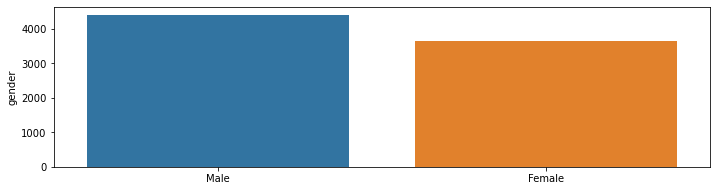

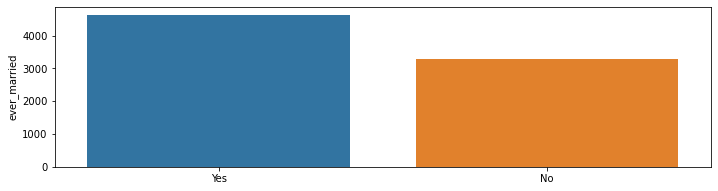

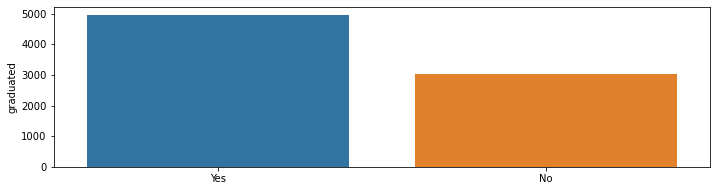

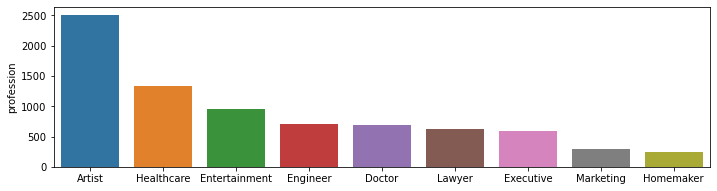

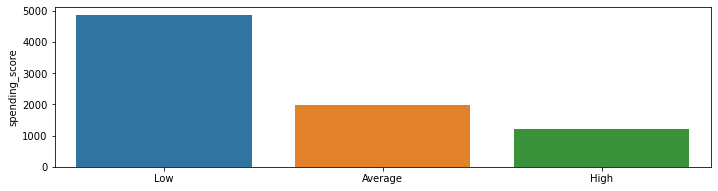

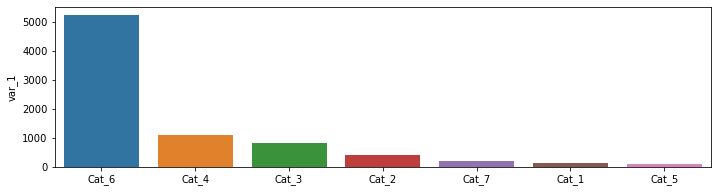

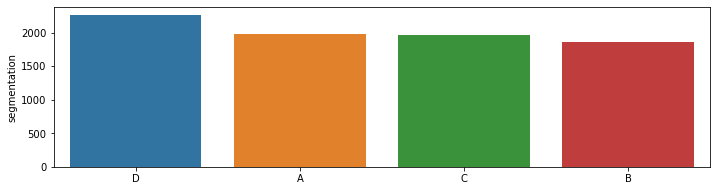

In [9]:
i = 1
for column in train_data.columns[~(train_data.columns.isin(['age', 'id', 'work_experience', 'family_size']))].tolist():
    plt.figure(figsize = (40, 10))
    plt.subplot(3, 3, i)
    sns.barplot(x = train_data[column].value_counts().index, y = train_data[column].value_counts())
    i += 1
    plt.show()

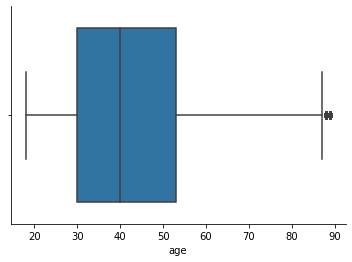

In [10]:
sns.boxplot(x = 'age', data = train_data)
sns.despine()

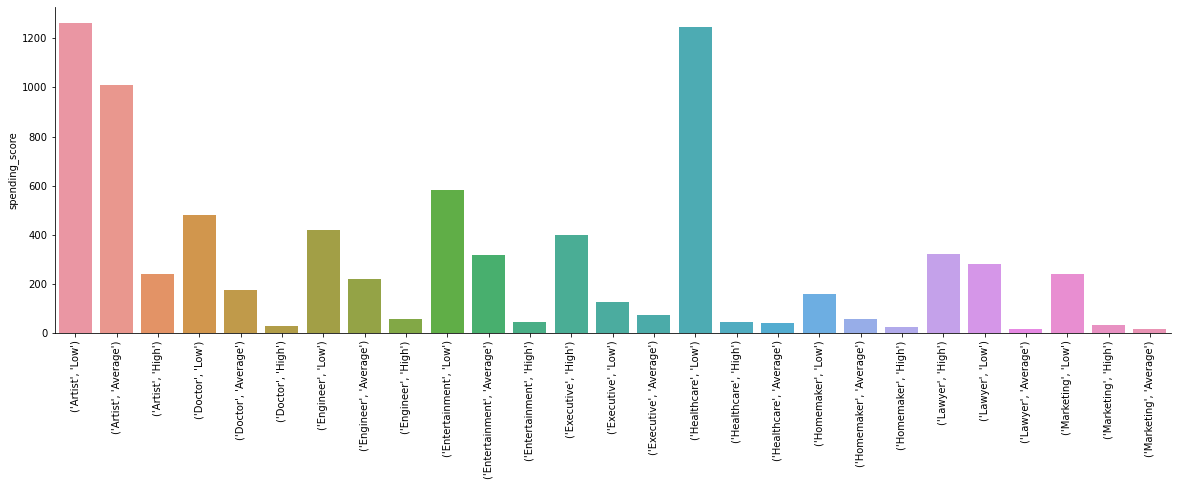

In [11]:
plt.figure(figsize = (20, 6))
sns.barplot(x = train_data.groupby(['profession'])['spending_score'].value_counts().index, y = train_data.groupby(['profession'])['spending_score'].value_counts())
plt.xticks(rotation = 90)
sns.despine()

### Found additional info by sorting the data (train + test) by IDs

In [12]:
train_data['type'] = 'train'
test_data['type'] = 'test'
train_data = train_data.drop('age', axis = 1)
test_data = test_data.drop('age', axis = 1)
master_data = pd.concat([train_data, test_data])
train_seg = train_data[['id', 'segmentation']]
train_seg.columns = ['id', 'assumed_seg']
master_data = master_data.merge(train_seg, on = 'id', how = 'left')
#master_data = master_data.sort_values(['id', 'type'], ascending = [True, False])
master_data.head(20)

,id,gender,ever_married,graduated,profession,work_experience,spending_score,family_size,var_1,segmentation,type,assumed_seg
0,462809,Male,No,No,Healthcare,1.0,Low,4.0,Cat_4,D,train,D
1,462643,Female,Yes,Yes,Engineer,NaN,Average,3.0,Cat_4,A,train,A
2,466315,Female,Yes,Yes,Engineer,1.0,Low,1.0,Cat_6,B,train,B
3,461735,Male,Yes,Yes,Lawyer,0.0,High,2.0,Cat_6,B,train,B
4,462669,Female,Yes,Yes,Entertainment,NaN,High,6.0,Cat_6,A,train,A
5,461319,Male,Yes,No,Artist,0.0,Average,2.0,Cat_6,C,train,C
6,460156,Male,No,Yes,Healthcare,1.0,Low,3.0,Cat_6,C,train,C
7,464347,Female,No,Yes,Healthcare,1.0,Low,3.0,Cat_6,D,train,D
8,465015,Female,Yes,Yes,Engineer,0.0,Low,3.0,Cat_7,D,train,D
9,465176,Female,Yes,Yes,Artist,1.0,Average,4.0,Cat_6,C,train,C


## Model Building

### Label Encoding the columns and removing insignificant columns

--> The work experience and family size is insignificant as per deduced by observing the sorted data

In [13]:
# master_data['age_bckt'] = pd.cut(x = master_data['age'], bins = [0, 22, 32, 42, 52, 62, 90], labels = ['1', '2', '3', '4', '5', '6'])

le = LabelEncoder()
cat_cols = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1', 'assumed_seg']

for col in cat_cols:
    master_data[col] = master_data[col].astype(str)
    LE = le.fit(master_data[col])
    master_data[col] = LE.transform(master_data[col])
    
train_data = master_data.loc[master_data['type'] == 'train']
test_data = master_data.loc[master_data['type'] == 'test']

testIDs = test_data.id.values

train_data = train_data.drop(['id', 'type', 'family_size', 'work_experience'], axis = 1)
test_data = test_data.drop(['id', 'segmentation', 'type', 'family_size', 'work_experience'], axis = 1)

train_data = train_data.fillna('NaN')
test_data = test_data.fillna('NaN')

# Partitioning the features and the target

X = train_data[train_data.columns[~(train_data.columns.isin(['segmentation']))].tolist()].values
y = train_data['segmentation'].values

train_data.head()

,gender,ever_married,graduated,profession,spending_score,var_1,segmentation,assumed_seg
0,1,0,0,5,2,3,D,3
1,0,1,1,2,0,3,A,0
2,0,1,1,2,2,5,B,1
3,1,1,1,7,1,5,B,1
4,0,1,1,3,1,5,A,0


### LGBM Classifier with RepeatedStratifiedKFold

In [14]:
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 22)
n_scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X, y)
# make a single prediction
yhat = (model.predict(test_data)).ravel()
print('Prediction: ', yhat)

Accuracy: 1.000 (0.000)
Prediction:  ['B' 'C' 'A' ... 'D' 'B' 'D']


In [15]:
pred = pd.DataFrame()
#pred['ID'] = test_data['id'].values
pred['ID'] = testIDs
pred['Segmentation'] = pd.Series((model.predict(test_data)).ravel())
pred.to_csv('lgbm_v1.csv', index = None)

### Catboost Regressor with kFold

In [16]:
kfold, scores = KFold(n_splits = 6, shuffle = True, random_state = 22), list()
for train, test in kfold.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    model = CatBoostClassifier(random_state = 22, max_depth = 6, n_estimators = 200, verbose = 100)
    model.fit(X_train, y_train, cat_features = [0,1,2,3,4,5,6])
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)
    scores.append(score)
    print('Validation Accuracy:', score)
print("Average Validation Accuracy: ", sum(scores)/len(scores))

Learning rate set to 0.339749
0:	learn: 0.5760959	total: 71.4ms	remaining: 14.2s
100:	learn: 0.0008687	total: 2.34s	remaining: 2.3s
199:	learn: 0.0003643	total: 4.66s	remaining: 0us
Validation Accuracy: 1.0
Learning rate set to 0.339749
0:	learn: 0.5760959	total: 18.2ms	remaining: 3.62s
100:	learn: 0.0008877	total: 2.34s	remaining: 2.29s
199:	learn: 0.0003614	total: 4.93s	remaining: 0us
Validation Accuracy: 1.0
Learning rate set to 0.339749
0:	learn: 0.5760960	total: 18.5ms	remaining: 3.69s
100:	learn: 0.0010560	total: 2.37s	remaining: 2.32s
199:	learn: 0.0004137	total: 4.7s	remaining: 0us
Validation Accuracy: 1.0
Learning rate set to 0.339749
0:	learn: 0.5760960	total: 18.3ms	remaining: 3.64s
100:	learn: 0.0011187	total: 2.32s	remaining: 2.28s
199:	learn: 0.0004181	total: 4.6s	remaining: 0us
Validation Accuracy: 1.0
Learning rate set to 0.339752
0:	learn: 0.5771824	total: 21.6ms	remaining: 4.29s
100:	learn: 0.0008328	total: 2.39s	remaining: 2.35s
199:	learn: 0.0003990	total: 4.83s	rem

In [17]:
pred = pd.DataFrame()
#pred['ID'] = test_data['id'].values
pred['ID'] = testIDs
pred['Segmentation'] = pd.Series((model.predict(test_data)).ravel())
pred.to_csv('catboost_v1.csv', index = None)

### Public leaderboard score (LGBM): Accuracy - 92%